# Outlier Detection With Autoencoders

based on: https://towardsdatascience.com/outlier-detection-with-autoencoders-6c7ac3e2aa90

<b> environment

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<b> Helper functions to create data

In [25]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Arbitrary pattern"""
    return np.where(season_time < 0.1,np.cos(season_time * 7 * np.pi),1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

<b> Define data

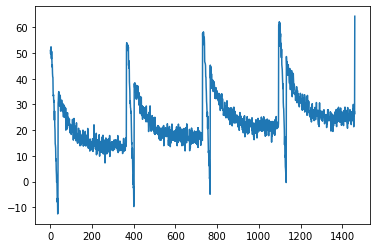

In [28]:
y_intercept = 10
slope = 0.01
amplitude = 40
noise_level = 2

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, slope) + y_intercept
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

plt.plot(time, series)

<b> Define outliers

In [3]:
SERIES_WITH_OUTLIERS = SERIES
SERIES_WITH_OUTLIERS[500] = 100
SERIES_WITH_OUTLIERS[1000] = -100

<b> Plot data

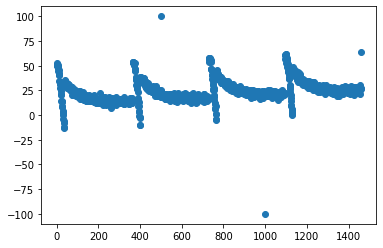

In [4]:
plt.scatter(TIME, SERIES_WITH_OUTLIERS)

In [5]:
def train_val_split(time, series, time_step):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid
# Split the dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ### START CODE HERE
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    ### END CODE HERE
    return dataset

SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES, SPLIT_TIME)
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)


TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(SERIES)
print("Training input shape: ", x_train.shape)


Training input shape:  (1174, 288)


<b> Define autoencoder model

In [6]:
encoder = tf.keras.Sequential([
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=16)
])

decoder = tf.keras.Sequential([
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=288)
])
autoencoder = tf.keras.Sequential([encoder,decoder])
autoencoder.compile(loss="mse")

<b> Training (without outliers)

In [7]:
autoencoder.fit(
    x=x_train,
    y=x_train,
    validation_split=0.2,
    epochs=500
)

Epoch 1/500
30/30 [==============================] - 1s 6ms/step - loss: 313.3952 - val_loss: 156.7811
Epoch 2/500
30/30 [==============================] - 0s 2ms/step - loss: 116.2944 - val_loss: 106.4428
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 107.2492 - val_loss: 113.6612
Epoch 4/500
30/30 [==============================] - 0s 2ms/step - loss: 106.8238 - val_loss: 113.7695
Epoch 5/500
30/30 [==============================] - 0s 2ms/step - loss: 106.5894 - val_loss: 103.7501
Epoch 6/500
30/30 [==============================] - 0s 2ms/step - loss: 106.0669 - val_loss: 99.2969
Epoch 7/500
30/30 [==============================] - 0s 2ms/step - loss: 105.2458 - val_loss: 102.4106
Epoch 8/500
30/30 [==============================] - 0s 2ms/step - loss: 103.9919 - val_loss: 103.7313
Epoch 9/500
30/30 [==============================] - 0s 2ms/step - loss: 101.3224 - val_loss: 100.0879
Epoch 10/500
30/30 [==============================] - 0s 2ms/step - loss: 

<b> Inference (Reconstruct points with outliers)

In [8]:
x_train_pred = autoencoder.predict(x_train)

<b> Plot reconstructed points

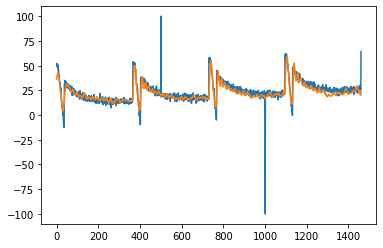

In [24]:
X_pred = np.array(x_train_pred[0])
for window in x_train_pred:
    X_pred = np.append(X_pred, window[-1])

X = np.array(x_train[0])
for window in x_train:
    X = np.append(X, window[-1])
    

plt.plot(X)
plt.plot(X_pred)

<b> Reconstruction error

In [ ]:
reconstruction_errors = tf.reduce_sum((autoencoder(points_with_outliers) - points_with_outliers)**2, axis=1)

pd.DataFrame({
    "x": points_with_outliers[:, 0],
    "y": points_with_outliers[:, 1],
    "reconstruction_error": reconstruction_errors
})